In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from sklearn.metrics import accuracy_score
import numpy as np
import scipy

In [2]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [3]:
train_data_dir = '/Users/gustavodias/Desktop/ArcStyles/train'
test_data_dir = '/Users/gustavodias/Desktop/ArcStyles/test'

class_subset = sorted(os.listdir('/Users/gustavodias/Desktop/ArcStyles/train'))[1:6] # Using only the first 10 classes

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 182 images belonging to 5 classes.
Found 31 images belonging to 5 classes.
Found 48 images belonging to 5 classes.


In [4]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=5

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 1000

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [6]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/Users/gustavodias/Downloads/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

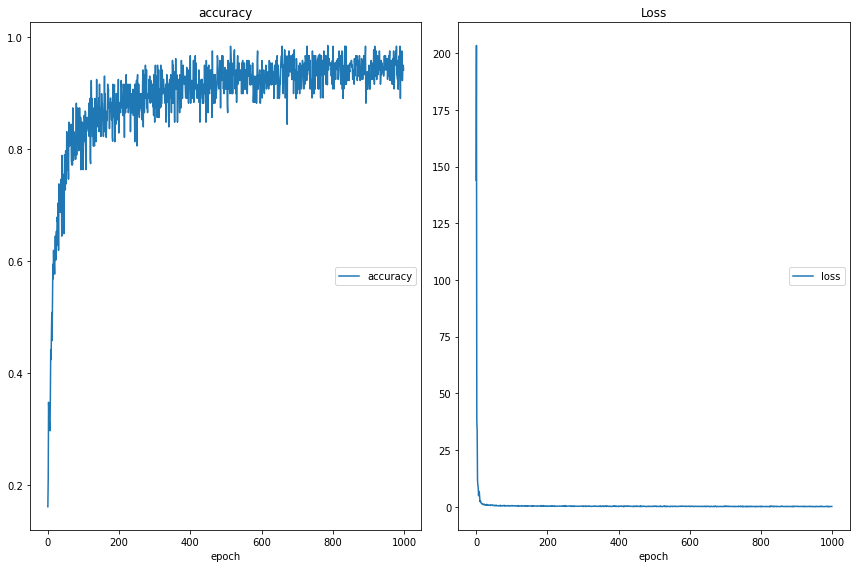

accuracy
	accuracy         	 (min:    0.161, max:    0.984, cur:    0.941)
Loss
	loss             	 (min:    0.054, max:  203.358, cur:    0.169)
2/2 [==============================] - 4s 2s/step - loss: 0.1685 - accuracy: 0.9407
CPU times: user 1h 30min 52s, sys: 13min 40s, total: 1h 44min 32s
Wall time: 1h 21min 47s


In [7]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [8]:
# Generate predictions
vgg_model.load_weights('/Users/gustavodias/Downloads/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

48/48 [==============================] - 1s 23ms/step


In [9]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4], dtype=int32)

In [10]:
class_indices

{0: 'Barroca',
 1: 'Indigenous',
 2: 'Modernista',
 3: 'Neoclassica',
 4: 'Neogotico'}

In [11]:
vgg_pred_classes

array([0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 0, 3, 3, 3, 4, 3, 2, 3, 4, 2, 0, 4, 4, 2,
       4, 4, 4, 4])

In [12]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 79.17%


In [13]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


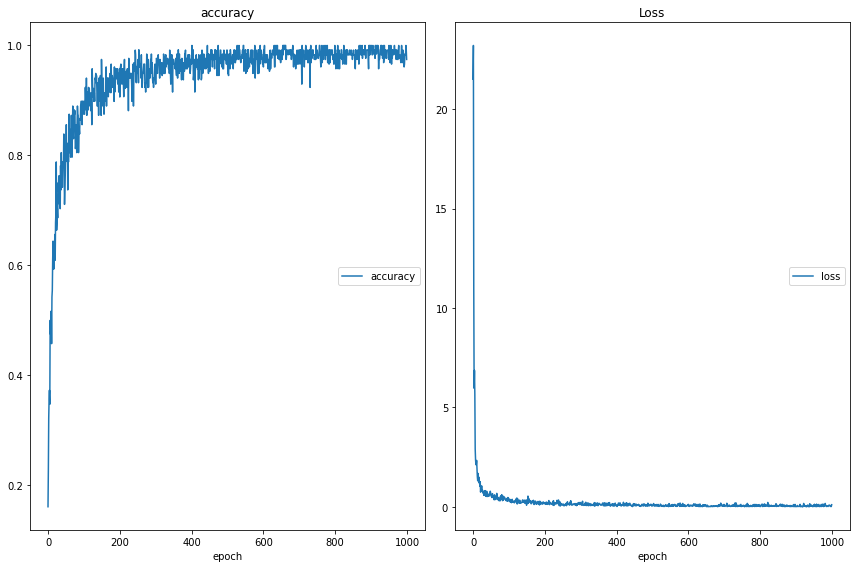

accuracy
	accuracy         	 (min:    0.161, max:    1.000, cur:    0.975)
Loss
	loss             	 (min:    0.003, max:   23.199, cur:    0.105)
2/2 [==============================] - 4s 2s/step - loss: 0.1048 - accuracy: 0.9746
CPU times: user 1h 31min 6s, sys: 15min 50s, total: 1h 46min 56s
Wall time: 1h 22min 51s


In [14]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [15]:
# Generate predictions
vgg_model_ft.load_weights('/Users/gustavodias/Downloads/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

48/48 [==============================] - 1s 23ms/step


In [16]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 77.08%


In [17]:
vgg_model.save('/Users/gustavodias/Desktop/ArcStyles/saved_model_h5_5_no_ft.h5')
vgg_model_ft.save('/Users/gustavodias/Desktop/ArcStyles/saved_model_h5_5_ft.h5')

In [19]:
import coremltools as ct
coreml_model = ct.convert(vgg_model, inputs=[ct.ImageType(name='image', shape=model.input_shape[1:])])

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 166/166 [00:43<00:00,  3.85 ops/s]


In [20]:
coreml_model.save('/Users/gustavodias/Downloads/saved_model_h5_5_no_ft.mlmodel')

In [21]:
coreml_model = ct.convert(vgg_model_ft, inputs=[ct.ImageType(name='image', shape=model.input_shape[1:])])

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 166/166 [00:42<00:00,  3.94 ops/s]


In [22]:
coreml_model.save('/Users/gustavodias/Downloads/saved_model_h5_5_ft.mlmodel')